In [1]:
! ls RegMz* >mz_fft.txt

In [3]:
!cat mz_fft.txt

RegMz_4_j_0.22918311805232927_beta_0.hdf5
RegMz_4_j_0.22918311805232927_beta_1.5.hdf5
RegMz_4_j_0.22918311805232927_beta_2.5.hdf5
RegMz_4_j_0.22918311805232927_beta_inf.hdf5
RegMz_4_j_0.6366197723675814_beta_0.hdf5
RegMz_4_j_0.6366197723675814_beta_1.5.hdf5
RegMz_4_j_0.6366197723675814_beta_2.5.hdf5
RegMz_4_j_0.6366197723675814_beta_inf.hdf5
RegMz_6_j_0.22918311805232927_beta_0.hdf5
RegMz_6_j_0.22918311805232927_beta_1.5.hdf5
RegMz_6_j_0.22918311805232927_beta_2.5.hdf5
RegMz_6_j_0.22918311805232927_beta_inf.hdf5
RegMz_6_j_0.6366197723675814_beta_0.hdf5
RegMz_6_j_0.6366197723675814_beta_1.5.hdf5
RegMz_6_j_0.6366197723675814_beta_2.5.hdf5
RegMz_6_j_0.6366197723675814_beta_inf.hdf5
RegMz_8_j_0.22918311805232927_beta_0.hdf5
RegMz_8_j_0.22918311805232927_beta_1.5.hdf5
RegMz_8_j_0.22918311805232927_beta_2.5.hdf5
RegMz_8_j_0.22918311805232927_beta_inf.hdf5
RegMz_8_j_0.6366197723675814_beta_0.hdf5
RegMz_8_j_0.6366197723675814_beta_1.5.hdf5
RegMz_8_j_0.6366197723675814_beta_2.5.hdf5
RegMz_8_j_0

## FFT beat frequency change with system size

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.03it/s]


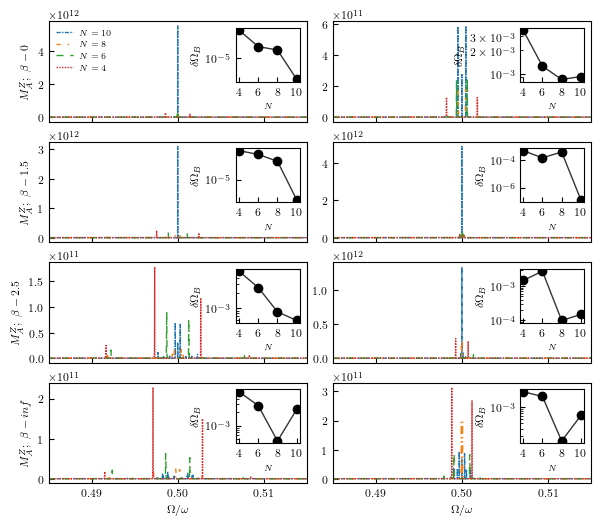

In [55]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel
from tqdm import tqdm
from scipy import interpolate 

plt.rcParams.update({"figure.figsize": (7,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 8,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 2, sharey=False, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

freq_threshold = 0.01
legendftsize = 6

omega = 20.0
w = omega
T = 2 * np.pi/w

with open("mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    #btfr = np.zeros((2,4))
    
    btfr = np.zeros((4,2,4))
    betas = np.zeros((4,4))
    Ns = np.zeros((4,2,4))
    
    for xx in tqdm(range(0,x)):
        filename = lines[xx][:-1]
        
        with h5py.File(filename, "r") as f:
            mz_data_a = f['mza'][()]
            mz_data_b = f['mzb'][()]
            times = f['times'][()]            
            beta = f.attrs['beta']
            Jvalue = f.attrs['Jvalue']              
            N = f.attrs['N']
            w = f.attrs['w']
            
            T = 2 * np.pi/w
            
            if Jvalue == 0.072/T:
                jj = 0
                Jvalue1 = Jvalue
            if Jvalue == 0.2/T:
                jj = 1
                Jvalue2 = Jvalue
                
            infbeta = float('inf')            
            if beta ==0:
                b = 0
            if beta ==1.5:
                b = 1
            if beta ==2.5:
                b = 2            
            if beta ==infbeta:
                b = 3
                
            if N == 4:
                n = 0
            if N == 6:
                n = 1
            if N == 8:   
                n = 2        
            if N == 10:
                n = 3
            '''
            if N == 12:
                n = 4         
            '''
            #-------  FFT   ----------------------------------------------------------------            
            frequencies = T * np.fft.fftfreq(mz_data_a.size, d = times[-1]/len(times))
            fft_values = np.fft.fft(mz_data_a - np.average(mz_data_a))
            
            mask = (frequencies > freq_threshold) & (frequencies < 1.0)
            y = np.abs(fft_values[mask])**2
            x = frequencies[mask]
            
            line, = axs[b][jj].plot(x, y,linewidth=1,label = fr'$N={N}$', linestyle = linestyle_tuple[n][1])     
            
            #-------  Find FFT Peaks and Beats frequencies   -----------------------------------------
            peak_idx, peak_props = find_peaks(y, prominence = 1, distance = None, height = 1.0e10)
            peak_pos = x[peak_idx]                     
                        
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            # If before_proms is empty, then put beat_freq  = 0
            if len(peaks_before) == 0:
                prominent_freq_before= 0.5
            else:      
                most_prominent_idx = np.argmax(before_proms)
                prominent_freq_before = peaks_before[most_prominent_idx]
            
            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            # If after_proms is empty, then put beat_freq  = 0
            if len(peaks_after) == 0:
                prominent_freq_after = 0.5
            else:
                most_prominent_idx = np.argmax(after_proms)
                prominent_freq_after = peaks_after[most_prominent_idx]
                            
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before) 
            betas[jj][b] = beta
                
            if N == 4:
                btfr[0][jj][b] = beat_freq
                Ns[0][jj][b] = N
            if N == 6:
                btfr[1][jj][b] = beat_freq
                Ns[1][jj][b] = N
            if N == 8:
                btfr[2][jj][b] = beat_freq
                Ns[2][jj][b] = N  
            if N == 10:
                btfr[3][jj][b] = beat_freq
                Ns[3][jj][b] = N
            '''
            if N == 12:
                btfr[1][jj][b] = beat_freq  
                Ns[3][jj][b] = N     
            '''                    
            axs[b][jj].tick_params(which='both', axis="both", direction="in")
            axs[b][jj].set_xlim(0.485,.515)
            axs[0][0].legend(fontsize = legendftsize, frameon = False, loc =2)
            #axs[b][jj].text(0.487, 1.7e11, fr"$\beta-{beta}$", fontsize= 7)            
            axs[b][0].set_ylabel(fr"$M^Z_A;~\beta-{beta}$")   
            axs[-1][jj].set_xlabel(r"$\Omega/\omega$")
            axs[-1][jj].set_xticks([0.49,.5,.51])   
              
for jj in range(2):
    for b in range(4):
        left, bottom, width, height = [0.82, 0.4, 0.41, 1.2]
        inset = inset_axes(axs[b][jj], width="60%", height="45%",loc = "upper right",\
                              bbox_to_anchor=([left, bottom, width, height]),\
                              bbox_transform=axs[b][jj].transAxes, borderpad=6)
        nst = Ns.T
        btfrt = btfr.T
        inset.scatter(nst[b][jj], btfrt[b][jj], color ='black')
        inset.plot(nst[b][jj], btfrt[b][jj], color ='black', alpha = 0.8, linewidth = 1)

        
        inset.set_xlabel('$N$', fontsize = 6)
        inset.set_ylabel('$\delta \Omega_B$')        
        inset.set_yscale('log')
        inset.set_xticks(nst[b][jj])
        #inset.set_xticks([4,6,8,10], fontsize = 6)   
        inset.tick_params(which='both', axis="both", direction="in")
        #inset.set_ylim(1e-7, 1e-2)

figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_FFT_strong.svg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()

# calibrate the height we need to calculate the beats frequency

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.12it/s]


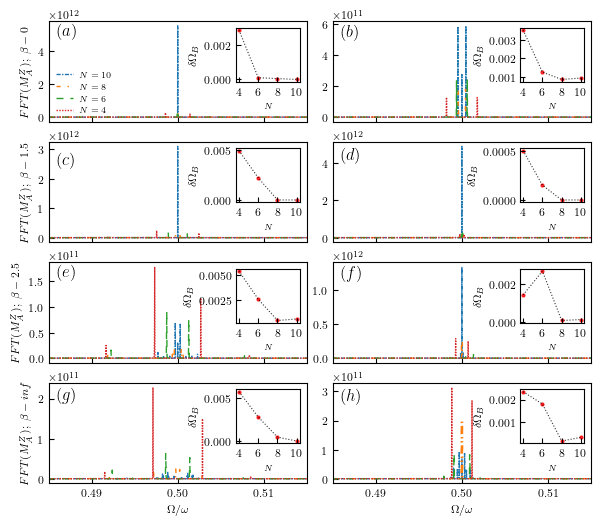

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel
from tqdm import tqdm
from scipy import interpolate 

plt.rcParams.update({"figure.figsize": (7,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 8,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 2, sharey=False, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

freq_threshold = 0.01
legendftsize = 6

omega = 20.0
w = omega
T = 2 * np.pi/w

with open("mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    #btfr = np.zeros((2,4))
    
    btfr = np.zeros((4,2,4))
    betas = np.zeros((4,4))
    Ns = np.zeros((4,2,4))
    
    for xx in tqdm(range(0,x)):
        filename = lines[xx][:-1]
        
        with h5py.File(filename, "r") as f:
            mz_data_a = f['mza'][()]
            mz_data_b = f['mzb'][()]
            times = f['times'][()]            
            beta = f.attrs['beta']
            Jvalue = f.attrs['Jvalue']              
            N = f.attrs['N']
            w = f.attrs['w']
            
            T = 2 * np.pi/w
            
            if Jvalue == 0.072/T:
                jj = 0
                Jvalue1 = Jvalue
            if Jvalue == 0.2/T:
                jj = 1
                Jvalue2 = Jvalue
                
            infbeta = float('inf')            
            if beta ==0:
                b = 0
            if beta ==1.5:
                b = 1
            if beta ==2.5:
                b = 2            
            if beta ==infbeta:
                b = 3
                
            if N == 4:
                n = 0
            if N == 6:
                n = 1
            if N == 8:   
                n = 2        
            if N == 10:
                n = 3
            '''
            if N == 12:
                n = 4         
            '''
            #-------  FFT   ----------------------------------------------------------------            
            frequencies = T * np.fft.fftfreq(mz_data_a.size, d = times[-1]/len(times))
            fft_values = np.fft.fft(mz_data_a - np.average(mz_data_a))
            
            mask = (frequencies > freq_threshold) & (frequencies < 1.0)
            y = np.abs(fft_values[mask])**2
            x = frequencies[mask]
            
            line, = axs[b][jj].plot(x, y,linewidth=1,label = fr'$N={N}$', linestyle = linestyle_tuple[n][1])     

            hgt = 2e10
            if (b==3) & (n==3):
                hgt = 9e10
            if (b==1) & (n==2):
                hgt = 9e11
            
            #-------  Find FFT Peaks and Beats frequencies   -----------------------------------------
            peak_idx, peak_props = find_peaks(y, prominence = 1, distance = None, height = hgt)
            peak_pos = x[peak_idx]                     
                        
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            # If before_proms is empty, then put beat_freq  = 0
            if len(peaks_before) == 0:
                prominent_freq_before= 0.5
            else:      
                most_prominent_idx = np.argmax(before_proms)
                prominent_freq_before = peaks_before[most_prominent_idx]
            
            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            # If after_proms is empty, then put beat_freq  = 0
            if len(peaks_after) == 0:
                prominent_freq_after = 0.5
            else:
                most_prominent_idx = np.argmax(after_proms)
                prominent_freq_after = peaks_after[most_prominent_idx]
                            
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before) 
            betas[jj][b] = beta
                
            if N == 4:
                btfr[0][jj][b] = beat_freq
                Ns[0][jj][b] = N
            if N == 6:
                btfr[1][jj][b] = beat_freq
                Ns[1][jj][b] = N
            if N == 8:
                btfr[2][jj][b] = beat_freq
                Ns[2][jj][b] = N  
            if N == 10:
                btfr[3][jj][b] = beat_freq
                Ns[3][jj][b] = N
            '''
            if N == 12:
                btfr[1][jj][b] = beat_freq  
                Ns[3][jj][b] = N     
            '''                    
            axs[b][jj].tick_params(which='both', axis="both", direction="in")
            axs[b][jj].set_xlim(0.485,.515)
            axs[0][0].legend(fontsize = legendftsize, frameon = False, loc =3)
            axs[b][0].set_ylabel(fr"$FFT(M^Z_A);~\beta-{beta}$")   
            axs[-1][jj].set_xlabel(r"$\Omega/\omega$")
            axs[-1][jj].set_xticks([0.49,.5,.51])   
              
for jj in range(2):
    for b in range(4):
        left, bottom, width, height = [0.82, 0.4, 0.41, 1.2]
        inset = inset_axes(axs[b][jj], width="60%", height="45%",loc = "upper right",\
                              bbox_to_anchor=([left, bottom, width, height]),\
                              bbox_transform=axs[b][jj].transAxes, borderpad=6)
        nst = Ns.T
        btfrt = btfr.T
        inset.scatter(nst[b][jj], btfrt[b][jj], color ='red', s = 4.0,alpha = 0.8)
        inset.plot(nst[b][jj], btfrt[b][jj], color ='black', alpha = 0.8, linewidth = 0.8, linestyle = 'dotted')

        
        inset.set_xlabel('$N$', fontsize = 6)
        inset.set_ylabel('$\delta \Omega_B$')        
        #inset.set_yscale('log')
        inset.set_xticks(nst[b][jj])
        #inset.set_xticks([4,6,8,10], fontsize = 6)   
        inset.tick_params(which='both', axis="both", direction="in")
        #inset.set_ylim(1e-7, 1e-2)

axs[0][0].text(0.486, 5e12, r"$(a)$", fontsize= 12)       
axs[0][1].text(0.486, 5.2e11, r"$(b)$", fontsize= 12)    
axs[1][0].text(0.486, 2.5e12, r"$(c)$", fontsize= 12)       
axs[1][1].text(0.486, 4.2e12, r"$(d)$", fontsize= 12)  
axs[2][0].text(0.486, 1.6e11, r"$(e)$", fontsize= 12)       
axs[2][1].text(0.486, 1.2e12, r"$(f)$", fontsize= 12)    
axs[3][0].text(0.486, 2.e11, r"$(g)$", fontsize= 12)       
axs[3][1].text(0.486, 2.7e11, r"$(h)$", fontsize= 12)  



figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_FFT_strong.svg'
#plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
#plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()